# 마르코프 체인 + HMM
## 데이터
- Google Merchadise Store GA -> 세션 단위로 session_id, visitDate, clean_page_sequence, converted, time_sequence
- 부적절한 데이터 : 순서 없는 데이터, 극단적인 불균형, 너무 길거나 많은 시퀀스 등

## 마르코프 체인(전환 기여도 분석
- 전이확률 계산 : 각 페이지 -> 다음 페이지 확률
- 기여도 계산 : 페이지 제거 시 전환율 감소량 계산


## HMM 의도 상태 추정
- 숨은 상태 : 사용자의 실제 의도(탐색중, 구매의사형성,구매직전,이탈예정 등)
- 페이지 방문 패턴을 통해 상태 전이 확률까지 학습



In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
## 라이브러리 로드

# BigQuery
from google.cloud import bigquery

# viz libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.express as px

# viz settings
%matplotlib inline
sns.set()
init_notebook_mode(connected=True)

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
# Client 객체 생성
client = bigquery.Client(project = '755804531278')

# 데이터셋 참조경로(reference) 설정
# Kaggle커널에서는 bq_helper를 대신 사용할 수도 있다.
dataset_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')

# 해당 경로로부터 데이터셋 추출
dataset = client.get_dataset(dataset_ref)

In [ ]:
# 데이터셋을 테이블 단위로 보기
tables = list(client.list_tables(dataset))
table_names = sorted([t.table_id for t in tables])

# 테이블 단위로 간단한 정보 확인
print(f"""table 개수 : {len(tables)}
tables : {", ".join(table_names[:3])}, ...
date 범위 : {table_names[0][-8:]} ~ {table_names[-1][-8:]}""")

table 개수 : 368
tables : daily_total_visits, daily_visits, ga_sessions_20160801, ...
date 범위 : l_visits ~ 20170801


In [ ]:
# 테이블 경로 생성
table_ref_temp = dataset_ref.table(table_names[0])

# 테이블 가져오기
table_temp = client.get_table(table_ref_temp)

# 컬럼 확인
client.list_rows(table_temp, max_results=5).to_dataframe()

,visit_date,total_visits
0,2016-08-01,1711
1,2016-08-02,2140
2,2016-08-03,2890
3,2016-08-04,3161
4,2016-08-05,2702


In [ ]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [ ]:
# 테이블 생성하기
query = """
WITH hits_flat AS (
  SELECT
    fullVisitorId,
    visitId,
    CONCAT(CAST(fullVisitorId AS STRING), '.', CAST(visitId AS STRING)) AS session_id,
    PARSE_DATE('%Y%m%d', date) AS visitDate,
    LOWER(device.deviceCategory) AS deviceCategory,
    LOWER(geoNetwork.country) AS country,
    LOWER(trafficSource.source) AS source,
    LOWER(trafficSource.medium) AS medium,
    totals.newVisits AS isNewVisit,
    IFNULL(totals.transactions, 0) AS transactions,
    IFNULL(totals.totalTransactionRevenue, 0)/1e6 AS revenue,
    trafficSource.campaign AS campaign,
    hits.hitNumber,
    REGEXP_REPLACE(
      REGEXP_REPLACE(
        REGEXP_REPLACE(
          LOWER(REGEXP_REPLACE(hits.page.pagePath, r'(\?.*)$', '')),
        r'//+', '/'),
      r'(%20|\+)', '-')
    , r'\.html$', '') AS clean_path,
    hits.time AS ms_from_session_start,
    hits.isExit AS isExit,
    hits.isEntrance AS isEntrance
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
       UNNEST(hits) AS hits
  WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.type = 'PAGE'
),

session_level AS (
  SELECT
    session_id,
    ANY_VALUE(visitDate) AS visitDate,
    ANY_VALUE(deviceCategory) AS deviceCategory,
    ANY_VALUE(country) AS country,
    ANY_VALUE(source) AS source,
    ANY_VALUE(medium) AS medium,
    IF(MAX(IF(isNewVisit = 1, 1, 0)) = 1, 'New', 'Returning') AS userType,
    ANY_VALUE(campaign) AS campaign,
    ANY_VALUE(transactions) AS transactions,
    ANY_VALUE(revenue) AS revenue,

    ARRAY_AGG(clean_path ORDER BY ms_from_session_start, hitNumber) AS clean_page_sequence,
    ARRAY_AGG(CAST(ms_from_session_start AS INT64) ORDER BY ms_from_session_start, hitNumber) AS time_sequence,

    ARRAY_AGG(clean_path ORDER BY ms_from_session_start, hitNumber LIMIT 1)[OFFSET(0)] AS landingPagePath,
    ARRAY_REVERSE(ARRAY_AGG(clean_path ORDER BY ms_from_session_start, hitNumber))[OFFSET(0)] AS exitPagePath,

    -- 장바구니 도달 여부
    IF(
      SUM(
        CASE WHEN REGEXP_CONTAINS(clean_path, r'(^|/)basket([/?#.]|$)') THEN 1 ELSE 0 END
      ) > 0, 1, 0
    ) AS converted_basket,

    -- ✅ revenue 기반 전환 여부 (매출 발생 세션)
    CASE WHEN ANY_VALUE(revenue) > 0 THEN 1 ELSE 0 END AS converted_revenue

  FROM hits_flat
  GROUP BY session_id
),

filtered AS (
  SELECT *
  FROM session_level
  WHERE ARRAY_LENGTH(clean_page_sequence) >= 2
)

SELECT * FROM filtered;
"""

# 데이터프레임 생성
df = client.query(query).to_dataframe()

<>:21: SyntaxWarning:

invalid escape sequence '\?'

<>:21: SyntaxWarning:

invalid escape sequence '\?'

/tmp/ipython-input-2024615411.py:21: SyntaxWarning:

invalid escape sequence '\?'



In [ ]:
df

,session_id,visitDate,deviceCategory,country,source,medium,userType,campaign,transactions,revenue,clean_page_sequence,time_sequence,landingPagePath,exitPagePath,converted_basket,converted_revenue
0,3432596096943588822.1498022363,2017-06-20,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /store, /google-redesign/apparel/women...","[0, 289466, 549363, 601380, 876390, 918246, 10...",/home,/store,0,0
1,3456358389347920090.1497965452,2017-06-20,mobile,india,google,organic,New,(not set),0,0.00,"[/google-redesign/apparel/mens/mens-t-shirts, ...","[0, 36312, 79986, 120702, 121384, 139230, 2199...",/google-redesign/apparel/mens/mens-t-shirts,/yourinfo,1,0
2,9633967008155017210.1498017532,2017-06-20,tablet,united states,google,organic,Returning,(not set),0,0.00,"[/google-redesign/apparel/mens/mens-t-shirts, ...","[0, 228657, 230577, 232547, 232614, 234623, 39...",/google-redesign/apparel/mens/mens-t-shirts,/store,1,0
3,0014262055593378383.1498025686,2017-06-20,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /google-redesign/apparel/womens/womens...","[0, 23270, 101368, 117713, 139821, 148833, 163...",/home,/google-redesign/apparel/mens/mens-t-shirts/qu...,1,0
4,3320564707991164259.1498026249,2017-06-20,desktop,united states,google,organic,New,(not set),0,0.00,"[/home, /home, /google-redesign/bags/backpacks...","[0, 3445, 15523, 35485, 45829, 150103, 180958,...",/home,/google-redesign/bags/backpacks/25l-classic-ru...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450633,274928241784014996.1472592054,2016-08-30,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /google-redesign/drinkware, /google-re...","[0, 9272, 26972, 31522, 36338, 82155, 88829, 1...",/home,/google-redesign/bags,0,0
450634,8541162479552380791.1472587142,2016-08-30,desktop,united states,(direct),(none),Returning,(not set),1,19.44,"[/home, /google-redesign/apparel/men--s/men--s...","[0, 13309, 31045, 43531, 53423, 57906, 75562, ...",/home,/ordercompleted,1,1
450635,1631114716503974240.1472586188,2016-08-30,desktop,united states,google,organic,Returning,(not set),0,0.00,[/google-redesign/apparel/men--s/men--s-t-shir...,"[0, 17758, 268875, 284412, 288743, 288881, 291...",/google-redesign/apparel/men--s/men--s-t-shirts,/payment,1,0
450636,8961785775115413973.1472589173,2016-08-30,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /home, /google-redesign/apparel/men--s...","[0, 10882, 24604, 37448, 83741, 89592, 175504,...",/home,/payment,1,0


In [ ]:
# 전이 카운트 테이블
query="""
-- 전이 카운트(마르코프용) : 완전 자족형 SQL
-- 데이터: bigquery-public-data.google_analytics_sample.ga_sessions_*
-- 기간 변경: _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'

WITH hits_flat AS (
  SELECT
    CONCAT(CAST(fullVisitorId AS STRING), '.', CAST(visitId AS STRING)) AS session_id,
    PARSE_DATE('%Y%m%d', date) AS visitDate,
    device.deviceCategory AS deviceCategory,
    geoNetwork.country AS country,
    trafficSource.source AS source,
    trafficSource.medium AS medium,
    totals.newVisits AS isNewVisit,                    -- 1: 신규, NULL: 재방문
    hits.hitNumber,
    hits.time AS ms_from_session_start,
    -- PagePath 정규화: 쿼리스트링 제거, 중복 슬래시 제거, 공백류(+,%20) 하이픈 변환
    REGEXP_REPLACE(
      REGEXP_REPLACE(
        REGEXP_REPLACE(hits.page.pagePath, r'(\?.*)$', ''),    -- ? 이후 제거
      r'//+', '/'),                                            -- // -> /
    r'(%20|\+)', '-')                                          -- 공백류 -> '-'
      AS clean_path
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
       UNNEST(hits) AS hits
  WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.type = 'PAGE'
),

session_seq AS (
  SELECT
    session_id,
    -- 시간 기준 정렬(같은 ms면 hitNumber로 tie-break)
    ARRAY_AGG(clean_path ORDER BY ms_from_session_start, hitNumber) AS seq_paths
  FROM hits_flat
  GROUP BY session_id
),

seq_with_tokens AS (
  -- 각 세션의 시퀀스 앞뒤로 START/EXIT 토큰을 추가
  SELECT
    session_id,
    ARRAY_CONCAT(['START'], seq_paths, ['EXIT']) AS seq
  FROM session_seq
  WHERE ARRAY_LENGTH(seq_paths) >= 1      -- 빈 세션 방지
),

pairs AS (
  -- 인접 전이쌍(from_state -> to_state) 추출
  SELECT
    session_id,
    seq[OFFSET(i)] AS from_state,
    seq[OFFSET(i+1)] AS to_state
  FROM seq_with_tokens, UNNEST(GENERATE_ARRAY(0, ARRAY_LENGTH(seq)-2)) AS i
)

SELECT
  from_state,
  to_state,
  COUNT(*) AS transition_count
FROM pairs
GROUP BY from_state, to_state
ORDER BY transition_count DESC;
"""

# 데이터프레임 생성
df2 = client.query(query).to_dataframe()

In [ ]:
df2

,from_state,to_state,transition_count
0,START,/home,616021
1,/home,EXIT,420576
2,/home,/home,222343
3,START,/google-redesign/shop-by-brand/youtube,81546
4,/google-redesign/shop-by-brand/youtube,EXIT,69069
...,...,...,...
56838,/google-redesign/accessories/pet/quickview,/google-redesign/apparel/men--s/men--s-outerwear,1
56839,/google-redesign/apparel/men-s-t-shirts/youtub...,/store-policies/shipping-information,1
56840,/google-redesign/accessories/stickers/quickview,/google-redesign/lifestyle/housewares/foam-can...,1
56841,/google-redesign/apparel/kids/kids-toddler/goo...,/google-redesign/drinkware,1


In [ ]:
!pip install hmmlearn

In [ ]:
# 단일 경로 정제 & 토큰화 함수
import re

def clean_page_path(path):
    match = re.match(r'^/([^/?]+)', path) # 첫 segment만
    if not match:
        return 'unknown'
    segment = match.group(1)
    cleaned = re.sub(r'\.html?|\.axd|\.htm', '', segment)
    cleaned = re.sub(r'[^\w]', '', cleaned) # 영숫자/밑줄만 남김
    cleaned = cleaned.replace('_', '')
    return cleaned.lower()

# 세션별 전체 경로(path_array)에 적용
df['clean_path_array'] = df['clean_page_sequence'].apply(
    lambda paths: [clean_page_path(p) for p in paths]
)

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

# Top‑K + OTHER 축약 (HMM/MC 모두에 동일 적용)
MUST_KEEP = {'basket','cart','checkout','revieworder','payment','signin','login','myaccount'}

def map_topk_other(seq, k=200):
    cnt = Counter([t for t in seq if isinstance(t, str)])
    top = {w for w,_ in cnt.most_common(k)} | MUST_KEEP
    return [ (t if t in top else 'OTHER') for t in seq ]

# 적용
df_fast = df.copy()
df_fast["clean_path_array"] = df_fast["clean_page_sequence"].apply(
    lambda paths: [clean_page_path(p) for p in paths]
)
# 연속중복 제거
def squash_consecutive(seq):
    out, prev = [], None
    for x in seq:
        if x and x != prev:
            out.append(x); prev = x
    return out

df_fast["clean_path_array"] = df_fast["clean_path_array"].apply(squash_consecutive)
df_fast = df_fast[df_fast["clean_path_array"].str.len().between(2, 100)].reset_index(drop=True)
df_fast["clean_path_array"] = df_fast["clean_path_array"].apply(map_topk_other)
df_fast["seq_tokens"] = df_fast["clean_path_array"].apply(lambda s: ["START"] + s + ["EXIT"])

In [ ]:
import re, numpy as np, pandas as pd
from collections import Counter

# 0) 전이 카운트
transition_counts = Counter()
state_out_counts = Counter()
for seq in df_fast["seq_tokens"].values:
    for i in range(len(seq) - 1):
        a, b = seq[i], seq[i+1]
        transition_counts[(a, b)] += 1
        state_out_counts[a] += 1

states = sorted({s for (a,b) in transition_counts for s in (a,b)})
state_index = {s:i for i,s in enumerate(states)}
n = len(states)
assert n > 0, "상태가 없습니다. df_fast['seq_tokens']를 확인하세요."

# 1) 전이확률행렬 P '채우기' (← 빠져있던 부분)
P = np.zeros((n, n), dtype=float)
for (a,b), c in transition_counts.items():
    i, j = state_index[a], state_index[b]
    denom = state_out_counts[a]
    if denom > 0:
        P[i, j] = c / denom

# 행합=1 보정(수치 안정화)
row_sum = P.sum(axis=1, keepdims=True)
nz = row_sum.squeeze() > 0
P[nz] /= row_sum[nz]

# 2) absorbing 라벨 & 분해 함수
BASKET_RE = re.compile(r'\b(basket|cart|checkout|revieworder|payment)\b', re.I)

def build_absorbing_labels(states, extra=('EXIT',)):
    labels = set(extra)
    labels.update([s for s in states if BASKET_RE.search(s)])
    return labels

def split_transient_absorbing(Pmat, states, absorbing_labels):
    idx_abs = [i for i,s in enumerate(states) if s in absorbing_labels]
    idx_tr  = [i for i in range(len(states)) if i not in idx_abs]
    Q = Pmat[np.ix_(idx_tr, idx_tr)]
    R = Pmat[np.ix_(idx_tr, idx_abs)]
    return idx_tr, idx_abs, Q, R

def basket_absorb_prob(Pmat, states, absorbing_labels):
    # 행합 보정
    Pnorm = Pmat.copy()
    rs = Pnorm.sum(axis=1, keepdims=True)
    nz = rs.squeeze() > 0
    Pnorm[nz] /= rs[nz]

    idx_tr, idx_abs, Q, R = split_transient_absorbing(Pnorm, states, absorbing_labels)
    if not idx_tr or 'START' not in states:
        return 0.0
    sid = states.index('START')
    if sid in idx_abs:  # START가 흡수로 분류되면 계산 불가
        return 0.0

    I = np.eye(Q.shape[0])
    try:
        N = np.linalg.inv(I - Q)
    except np.linalg.LinAlgError:
        N = np.linalg.inv(I - Q + 1e-8*np.eye(Q.shape[0]))
    B = N @ R

    start_tr = idx_tr.index(sid)
    abs_labels = [states[i] for i in idx_abs]
    basket_cols = [k for k,l in enumerate(abs_labels) if BASKET_RE.search(l)]
    return float(B[start_tr, basket_cols].sum()) if basket_cols else 0.0

def remove_state_and_rebalance(P, states, state_index, remove_state, exit_label='EXIT'):
    P2 = P.copy()
    i = state_index[remove_state]
    j_exit = state_index.get(exit_label, None)

    # remove_state로 가던 질량을 EXIT로 이동
    for r in range(P2.shape[0]):
        if r == i:
            continue
        lost = P2[r, i]
        if lost > 0:
            P2[r, i] = 0.0
            if j_exit is not None:
                P2[r, j_exit] += lost

    # 제거 상태는 고립(자기루프=1)
    P2[i, :] = 0.0
    P2[i, i] = 1.0

    # 최종 행합 재정규화
    rs = P2.sum(axis=1, keepdims=True)
    nz = rs.squeeze() > 0
    P2[nz] /= rs[nz]
    return P2

# 3) Base 전환확률 & Removal Effect
absorbing_labels = build_absorbing_labels(states, extra=('EXIT',))
base_conv_prob = basket_absorb_prob(P, states, absorbing_labels)

rows = []
for s in states:
    if s in ('START','EXIT') or BASKET_RE.search(s):
        continue
    P2 = remove_state_and_rebalance(P, states, state_index, s, exit_label='EXIT')
    after = basket_absorb_prob(P2, states, absorbing_labels)
    rows.append({
        "state": s,
        "base_basket_prob": base_conv_prob,
        "after_remove_basket_prob": after,
        "removal_effect": base_conv_prob - after
    })

removal_df = pd.DataFrame(rows).sort_values("removal_effect", ascending=False)

In [ ]:
print(f"[DEBUG] states={len(states)}, base_conv_prob={base_conv_prob:.4f}, removal_df.shape={removal_df.shape}")
display(removal_df.head(15))

[DEBUG] states=28, base_conv_prob=0.3565, removal_df.shape=(23, 4)


,state,base_basket_prob,after_remove_basket_prob,removal_effect
2,googleredesign,0.35652,0.060365,0.296155
4,home,0.35652,0.083344,0.273176
17,store,0.35652,0.304891,0.051629
15,signin,0.35652,0.316319,0.040201
0,asearch,0.35652,0.327385,0.029135
13,registersuccess,0.35652,0.345746,0.010774
19,storepolicies,0.35652,0.347577,0.008943
5,home2,0.35652,0.349389,0.007131
12,register,0.35652,0.351545,0.004975
22,yourinfo,0.35652,0.351671,0.004849


In [ ]:
# “특정 노드에서 시작했을 때” basket 흡수확률
def absorb_from(node_label, P, states, absorbing_labels):
    if node_label not in states:
        return np.nan
    # 행합 보정
    Pnorm = P.copy()
    rs = Pnorm.sum(axis=1, keepdims=True)
    nz = rs.squeeze() > 0
    Pnorm[nz] /= rs[nz]

    idx_tr, idx_abs, Q, R = split_transient_absorbing(Pnorm, states, absorbing_labels)
    node_id = states.index(node_label)
    if node_id in idx_abs:
        return 1.0 if BASKET_RE.search(node_label) else 0.0
    if node_id not in idx_tr:
        return np.nan

    I = np.eye(Q.shape[0])
    try:
        N = np.linalg.inv(I - Q)
    except np.linalg.LinAlgError:
        N = np.linalg.inv(I - Q + 1e-8*np.eye(Q.shape[0]))
    B = N @ R
    abs_labels = [states[i] for i in idx_abs]
    basket_cols = [k for k,l in enumerate(abs_labels) if BASKET_RE.search(l)]
    return float(B[idx_tr.index(node_id), basket_cols].sum()) if basket_cols else 0.0

for p in ["googleredesign","home","store","signin"]:
    print(p, round(absorb_from(p, P, states, absorbing_labels), 4))

googleredesign 0.3707
home 0.3389
store 0.4206
signin 0.3635


In [ ]:
def absorb_probs_all_nodes(P, states, absorbing_labels):
    """
    모든 상태별로: 해당 상태에서 시작했을 때 basket 흡수 확률 계산
    """
    results = []
    for node in states:
        prob = absorb_from(node, P, states, absorbing_labels)
        results.append({"state": node, "basket_absorb_prob": prob})
    return pd.DataFrame(results).sort_values("basket_absorb_prob", ascending=False).reset_index(drop=True)


# --- 실행 ---
absorbing_labels = build_absorbing_labels(states, extra=('EXIT',))
all_absorb_df = absorb_probs_all_nodes(P, states, absorbing_labels)

print("[Markov] 각 상태에서 basket 도달 확률")
display(all_absorb_df)

[Markov] 각 상태에서 basket 도달 확률


,state,basket_absorb_prob
0,basket,1.000000
1,payment,1.000000
2,revieworder,1.000000
3,yourinfo,0.823038
4,guestregister,0.685180
5,register,0.556466
6,storeitem,0.422001
7,registersuccess,0.421948
8,store,0.420628
9,specials,0.381458


In [ ]:
# 노드별 주요 유출 간선 Top‑N

def top_out_edges(node_label, transition_counts, topn=10):
    rows = []
    for (a,b), c in transition_counts.items():
        if a == node_label:
            rows.append((b, c))
    rows.sort(key=lambda x: x[1], reverse=True)
    return rows[:topn]

print("googleredesign out-edges:", top_out_edges("googleredesign", transition_counts, 10))
print("home out-edges:", top_out_edges("home", transition_counts, 10))

googleredesign out-edges: [('EXIT', 172859), ('home', 119668), ('basket', 110006), ('store', 31922), ('asearch', 25066), ('signin', 7114), ('storepolicies', 6002), ('storeitem', 1589), ('myaccount', 969), ('home2', 576)]
home out-edges: [('googleredesign', 277308), ('EXIT', 40920), ('signin', 21917), ('asearch', 15609), ('basket', 8330), ('store', 5670), ('storepolicies', 4699), ('home2', 2434), ('myaccount', 1519), ('storeitem', 145)]


In [ ]:
# 세그먼트별 재계산(신규/재방문, 디바이스, 채널)
def segment_mc(df_fast, seg_col, seg_value):
    sub = df_fast[df_fast[seg_col]==seg_value]
    if sub.empty: return None
    # 전이 카운트 재계산
    tc, oc = Counter(), Counter()
    for seq in sub["seq_tokens"].values:
        for i in range(len(seq)-1):
            a,b = seq[i], seq[i+1]; tc[(a,b)] += 1; oc[a] += 1
    states = sorted({s for (a,b) in tc for s in (a,b)})
    si = {s:i for i,s in enumerate(states)}
    P = np.zeros((len(states), len(states)))
    for (a,b), c in tc.items():
        i,j = si[a], si[b]; P[i,j] = c/oc[a]
    # 흡수/기본확률
    absorbing_labels = build_absorbing_labels(states, extra=('EXIT',))
    base = basket_absorb_prob(P, states, absorbing_labels)
    # removal
    rows=[]
    for s in states:
        if s in ('START','EXIT') or BASKET_RE.search(s): continue
        P2 = remove_state_and_rebalance(P, states, si, s, 'EXIT')
        after = basket_absorb_prob(P2, states, absorbing_labels)
        rows.append((s, base, after, base-after))
    return base, pd.DataFrame(rows, columns=['state','base','after','removal']).sort_values('removal', ascending=False)

# 예: 신규/재방문
for seg in ['New','Returning']:
    res = segment_mc(df_fast, 'userType', seg)
    if res:
        base, df_rem = res
        print(f"[{seg}] base={base:.4f}")
        display(df_rem.head(10))

[New] base=0.2794


,state,base,after,removal
2,googleredesign,0.279403,0.038598,0.240805
4,home,0.279403,0.053623,0.225781
15,store,0.279403,0.236469,0.042935
13,signin,0.279403,0.253855,0.025548
0,asearch,0.279403,0.255071,0.024332
11,registersuccess,0.279403,0.269877,0.009526
17,storepolicies,0.279403,0.271633,0.007771
5,home2,0.279403,0.275044,0.004359
10,register,0.279403,0.275529,0.003875
20,yourinfo,0.279403,0.277480,0.001924


[Returning] base=0.5097


,state,base,after,removal
2,googleredesign,0.509694,0.119596,0.390098
4,home,0.509694,0.162922,0.346772
15,signin,0.509694,0.429958,0.079736
17,store,0.509694,0.437283,0.072411
0,asearch,0.509694,0.472440,0.037254
5,home2,0.509694,0.494302,0.015392
13,registersuccess,0.509694,0.496318,0.013376
22,yourinfo,0.509694,0.497344,0.012350
9,myaccount,0.509694,0.498132,0.011563
19,storepolicies,0.509694,0.498264,0.011430


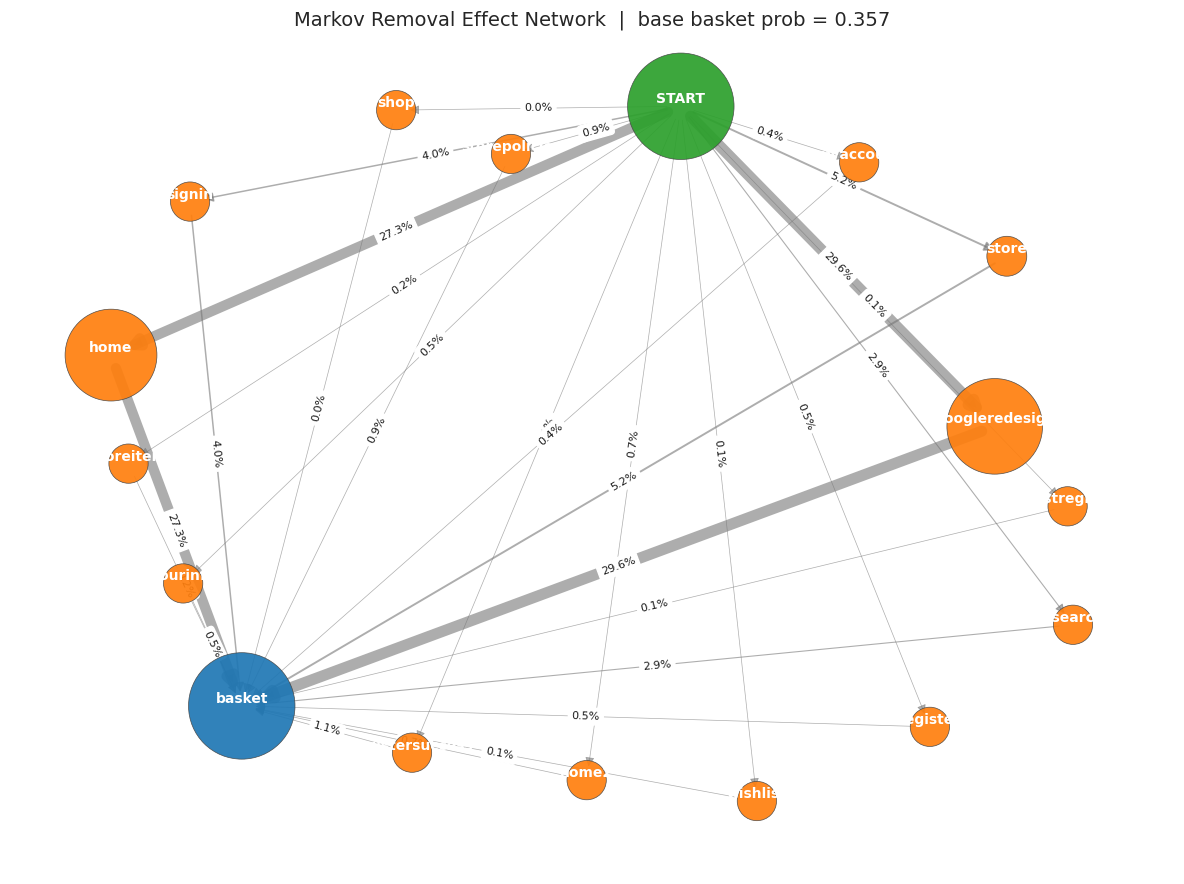

In [ ]:
import re
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

BASKET_RE = re.compile(r'\b(basket|cart|checkout|revieworder|payment)\b', re.I)

def plot_removal_network(
    removal_df: pd.DataFrame,
    base_basket_prob: float = None,
    top_n: int = 20,
    min_edge: float = 1e-4,
    seed: int = 42
):
    """
    Markov Removal Effect 네트워크 시각화(개선판)
    - 노드: START, 각 state, basket(정규식 매칭)
    - 엣지: START→state, state→basket (weight = removal_effect)
    - 노드 크기: removal_effect 크기
    - 색: START(녹), basket(파), 기타(주황)
    """
    req = {"state", "removal_effect"}
    assert req <= set(removal_df.columns), f"removal_df must contain {req}"

    df = removal_df.copy()
    df = df[df["removal_effect"] > 0].sort_values("removal_effect", ascending=False).head(top_n)

    if df.empty:
        print("[plot_removal_network] no positive removal edges to plot.")
        return

    # basket 라벨 결정
    uniq_states = set(df["state"].astype(str).tolist())  # 후보(시각화엔 state만 쓰지만 색 분류용)
    basket_label = "basket"
    # 혹시 basket 변형 라벨이 있으면 우선 사용
    for s in uniq_states:
        if BASKET_RE.search(s):
            basket_label = s
            break

    # 그래프 구성
    G = nx.DiGraph()
    for _, r in df.iterrows():
        s = str(r["state"])
        w = float(r["removal_effect"])
        if w <= min_edge:
            continue
        G.add_edge("START", s, weight=w)
        G.add_edge(s, basket_label, weight=w)

    if G.number_of_edges() == 0:
        print("[plot_removal_network] all edges under min_edge threshold.")
        return

    # 레이아웃
    k_val = 1.2 if G.number_of_nodes() < 25 else 2.0
    pos = nx.spring_layout(G, k=k_val, seed=seed)

    # 노드 스타일: 크기 = 연결된 removal 합
    node_w = {}
    for n in G.nodes():
        w_sum = 0.0
        for _, _, d in G.in_edges(n, data=True):
            w_sum += d.get("weight", 0.0)
        for _, _, d in G.out_edges(n, data=True):
            w_sum += d.get("weight", 0.0)
        node_w[n] = w_sum

    node_sizes = np.array([max(800.0, 8000.0 * node_w[n]) for n in G.nodes()])

    node_colors = []
    for n in G.nodes():
        if n == "START":
            node_colors.append("#2ca02c")  # green
        elif BASKET_RE.search(n) or n == "basket":
            node_colors.append("#1f77b4")  # blue
        else:
            node_colors.append("#ff7f0e")  # orange

    # 엣지 두께 자동 스케일링
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    w_max = max(weights)
    scale = 8.0 / w_max if w_max > 0 else 1.0  # 화면에 적절한 굵기
    edge_widths = [max(0.5, w * scale) for w in weights]

    plt.figure(figsize=(12, 9))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.92, linewidths=0.5, edgecolors="#444")
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6, edge_color="#777", arrows=True, arrowsize=14, min_source_margin=10, min_target_margin=10)

    # 라벨을 약간 위로 오프셋
    label_pos = {n: (x, y + 0.02) for n, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=10, font_color="white", font_weight="bold")

    # 엣지 라벨(%) — 너무 많으면 생략
    if G.number_of_edges() <= 40:
        edge_labels = {(u, v): f"{G[u][v]['weight']*100:.1f}%" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    title = "Markov Removal Effect Network"
    if base_basket_prob is not None:
        title += f"  |  base basket prob = {base_basket_prob:.3f}"
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# 사용 예시
plot_removal_network(removal_df, base_basket_prob=base_conv_prob, top_n=15)

In [ ]:
!pip install -U "hmmlearn>=0.3.0

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [ ]:
from hmmlearn.hmm import CategoricalHMM
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from collections import Counter

# 0) df_fast["seq"] 가 page 토큰 리스트라고 가정 (없다면 clean_path_array 쓰세요)
df_fast["seq"] = df_fast["clean_path_array"]

# 1) 토큰 인코딩 (0..n_features-1)
all_tokens = [p for s in df_fast["seq"] for p in s]
le = LabelEncoder().fit(list(Counter(all_tokens).keys()))
def enc(seq): return np.array(le.transform(seq), dtype=int)

encoded = [enc(s) for s in df_fast["seq"] if len(s)>0]
lengths = [len(s) for s in encoded]
X = np.concatenate(encoded).reshape(-1,1)   # ← 라벨(정수) 입력, 2D (T,1)

## 방법 1

In [ ]:
# 2) HMM 학습 (상태수는 3~5 추천)
N_STATES = 4
model = CategoricalHMM(n_components=N_STATES, n_iter=60, tol=1e-3, random_state=42, verbose=False)
model.fit(X, lengths)

# 3) 해석: 상태 전이/방출
print("transmat:\n", np.round(model.transmat_, 3))
em = np.round(model.emissionprob_, 4)       # (n_states, n_features)
vocab = le.classes_
for k in range(N_STATES):
    top = em[k].argsort()[::-1][:10]
    print(f"State {k}:", [(str(vocab[i]), float(em[k][i])) for i in top])

# 4) 세션별 상태 시퀀스 추정 (있으면 전환/비전환 비교)
def viterbi_states(e):
    _, st = model.decode(e.reshape(-1,1), algorithm="viterbi")
    return st

df_fast["state_seq"] = [viterbi_states(e) for e in encoded]

transmat:
 [[0.223 0.031 0.69  0.055]
 [0.061 0.    0.003 0.936]
 [0.974 0.012 0.013 0.   ]
 [0.423 0.577 0.    0.   ]]
State 0: [('basket', 0.4295), ('store', 0.1721), ('asearch', 0.0957), ('yourinfo', 0.0715), ('myaccount', 0.0455), ('revieworder', 0.042), ('registersuccess', 0.0414), ('storepolicies', 0.0304), ('signin', 0.0288), ('register', 0.0163)]
State 1: [('home', 0.9644), ('home2', 0.0101), ('asearch', 0.0081), ('store', 0.0064), ('basket', 0.0061), ('storepolicies', 0.0023), ('signin', 0.0018), ('storeitem', 0.0006), ('shop', 0.0001), ('eco', 0.0001)]
State 2: [('googleredesign', 0.5637), ('signin', 0.1682), ('payment', 0.1059), ('ordercompleted', 0.0489), ('store', 0.048), ('home', 0.017), ('yourinfo', 0.0159), ('myaccount', 0.01), ('storepolicies', 0.008), ('registersuccess', 0.0072)]
State 3: [('googleredesign', 0.8896), ('signin', 0.0634), ('asearch', 0.0245), ('storepolicies', 0.0094), ('store', 0.0055), ('basket', 0.0047), ('home2', 0.0018), ('myaccount', 0.0007), ('sh

In [ ]:
print(np.round(model.transmat_, 3))

[[0.223 0.031 0.69  0.055]
 [0.061 0.    0.003 0.936]
 [0.974 0.012 0.013 0.   ]
 [0.423 0.577 0.    0.   ]]


# 방법2
- START/EXIT는 관측 토큰이 아니라 경계 토큰이라 HMM 입력에서 제거
- 상태 수(K)는 3~6 범위에서 BIC로 고르면 해석력 좋아짐
- 상위 토큰만 보는 대신, **lift(상태 내 비중 / 전체 비중)**로 대표 토큰을 뽑으면 상태 의미가 선명
- state_seq를 df_fast 순서와 안전하게 매칭(인덱스 유지)하도록 보완

In [ ]:
! pip install --upgrade hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 731.9 kB/s eta 0:00:00


In [ ]:
from hmmlearn.hmm import CategoricalHMM
import numpy as np, time

def fit_with_progress(X, lengths, k=4, n_iter=80, tol=1e-3, seed=42, verbose_each=True):
    m = CategoricalHMM(
        n_components=k,
        n_iter=n_iter,      # 그냥 전체 반복
        tol=tol,
        random_state=seed,
        verbose=True        # 내부 진행상황 출력 (log likelihood)
    )
    t0 = time.perf_counter()
    m.fit(X, lengths)
    print(f"Elapsed {time.perf_counter()-t0:.1f}s")
    return m

# 사용 예시
model = fit_with_progress(X, lengths, k=4, n_iter=80, tol=1e-3, seed=42)


         1 -4709565.89521315             +nan
         2 -2347239.26533301 +2362326.62988013
         3 -2311994.74210029  +35244.52323272
         4 -2286384.94894643  +25609.79315387
         5 -2254357.26113109  +32027.68781533
         6 -2211446.00091880  +42911.26021229
         7 -2160972.75253616  +50473.24838264
         8 -2108394.55281611  +52578.19972005
         9 -2059468.81120202  +48925.74161409
        10 -2023261.33194377  +36207.47925824
        11 -1999793.95787737  +23467.37406640
        12 -1980300.11897376  +19493.83890362
        13 -1959722.31277291  +20577.80620085
        14 -1941518.76804151  +18203.54473140
        15 -1929786.93077531  +11731.83726620
        16 -1922209.35219341   +7577.57858189
        17 -1915874.69248229   +6334.65971112
        18 -1909730.29349359   +6144.39898870
        19 -1903894.97496202   +5835.31853157
        20 -1898972.85306465   +4922.12189737
        21 -1895265.89588669   +3706.95717796
        22 -1892342.44112541   +2

Elapsed 5928.5s


        80 -1868396.77443115      +2.29237820


In [ ]:
model

CategoricalHMM(n_components=4, n_features=np.int64(26), n_iter=80,
               random_state=RandomState(MT19937) at 0x7AC9EE8F4940, tol=0.001,
               verbose=True)

In [ ]:
import joblib
import networkx as nx
import matplotlib.pyplot as plt

# 저장된 모델 불러오기
bundle = joblib.load("./hmm_categorical_bundle2.joblib")
model = bundle["model"]
le = bundle["label_encoder"]

In [ ]:
model

CategoricalHMM(n_components=4, n_features=np.int64(26), n_iter=80,
               random_state=RandomState(MT19937) at 0x7F5D18085640, tol=0.001,
               verbose=True)

In [ ]:
print("Transition matrix:\n", model.transmat_)
print("Emission matrix:\n", model.emissionprob_)

Transition matrix:
 [[2.21084105e-01 3.15409695e-02 6.89479263e-01 5.78956619e-02]
 [6.11599012e-02 3.60574406e-24 1.12618930e-04 9.38727480e-01]
 [9.73396232e-01 1.40906915e-02 1.21012077e-02 4.11868293e-04]
 [4.29670891e-01 5.70327189e-01 1.92000187e-06 6.04560914e-16]]
Emission matrix:
 [[9.57799156e-002 4.31414704e-001 5.05040307e-005 1.34938394e-012
  1.43079745e-003 2.58789331e-003 6.80158081e-003 2.81099675e-006
  3.99310203e-106 1.85112504e-005 4.55106644e-002 1.98214696e-006
  5.24166398e-003 2.00922952e-003 1.62700504e-002 4.13757581e-002
  4.20693805e-002 1.29455810e-004 2.91559091e-002 7.85863906e-006
  1.72016140e-001 4.69382656e-003 3.04375463e-002 4.00858932e-006
  2.70820033e-003 7.02816079e-002]
 [7.75137884e-003 5.93518178e-003 1.39307106e-004 1.43749189e-028
  1.77815361e-053 9.65241341e-001 1.00404459e-002 2.03852644e-039
  0.00000000e+000 7.48058237e-006 1.03190882e-014 3.38800083e-006
  4.95337512e-100 1.37799081e-052 1.19304778e-031 2.09238317e-087
  1.35398306e-

In [ ]:
!pip install joblib

In [ ]:
import joblib

# 저장
bundle = {
    "model": model,   # 학습된 HMM 모델
    "label_encoder": le  # 상태/토큰 인코더
}
joblib.dump(bundle, "./hmm_categorical_bundle2.joblib")

print("저장 완료 ✅")

저장 완료 ✅


In [ ]:
import numpy as np
vocab = le.classes_
for k in range(model.n_components):
    top_idx = np.argsort(model.emissionprob_[k])[::-1][:10]
    print(f"State {k}:", [(vocab[i], model.emissionprob_[k][i]) for i in top_idx])


State 0: [(np.str_('basket'), np.float64(0.4314147036900727)), (np.str_('store'), np.float64(0.17201614047898012)), (np.str_('asearch'), np.float64(0.09577991559413677)), (np.str_('yourinfo'), np.float64(0.07028160792471015)), (np.str_('myaccount'), np.float64(0.04551066444509382)), (np.str_('revieworder'), np.float64(0.04206938052623669)), (np.str_('registersuccess'), np.float64(0.04137575805647645)), (np.str_('storepolicies'), np.float64(0.030437546335295978)), (np.str_('signin'), np.float64(0.029155909115539422)), (np.str_('register'), np.float64(0.016270050413327405))]
State 1: [(np.str_('home'), np.float64(0.9652413409903988)), (np.str_('home2'), np.float64(0.010040445886726255)), (np.str_('asearch'), np.float64(0.007751378837615986)), (np.str_('store'), np.float64(0.006143542946033928)), (np.str_('basket'), np.float64(0.00593518178440493)), (np.str_('storepolicies'), np.float64(0.002280511961930092)), (np.str_('signin'), np.float64(0.001779928189955345)), (np.str_('storeitem'), n

**State** 0 — “장바구니/체크아웃 집합(Checkout Hub)”

  - 상위 토큰: basket(0.43), store(0.17), asearch(0.096), yourinfo, myaccount, revieworder, registersuccess, signin …

  - 해석: 장바구니 및 결제 플로우 요소들과 계정/정보 입력 단계가 함께 나타남. 장바구니에 도달한 뒤 결제로 진입하거나, 계정/정보 입력으로 분기되는 구간.

- 시사점: 이 구간에서는 마찰 최소화가 핵심 (배송비/재고/반품정책의 가시화, 필수 입력 최소화, 오류메시지 개선, 게스트결제/간편결제 제공)

State 1 — “홈 허브(Home Hub)”

  - 상위 토큰: home(0.965)(+home2, asearch, store, basket 소량)

  - 해석: 거의 순수 홈 체류 상태. 홈에서 탐색을 시작하거나 재귀(홈↔다른 페이지)하는 패턴.

  - 시사점: 홈에서 상품 진입/장바구니 직결을 강화해야 전환이 빨라짐. 첫 화면에 베스트/세일/개인화 추천·딥링크·고정 CTA 배치.

State 2 — “구글리디자인 → 로그인/결제 진입(Conversion Entry via GRedesign)”

  - 상위 토큰: googleredesign(0.561), signin(0.166), payment(0.106), ordercompleted(0.050), store(0.049) …

  - 해석: googleredesign에서 바로 로그인/결제로 깊게 파고드는 전환 진입 클러스터. 완료(ordercompleted) 신호도 포함.

  - 시사점: googleredesign은 전환 관문. 여기서 로그인/결제로의 무마찰 경로(간편로그인, 결제 프로모 가시화, 상품·장바구니 복원)를 극대화.

State 3 — “구글리디자인 탐색(Exploration via GRedesign)”

  - 상위 토큰: googleredesign(0.888), signin(0.065), asearch(0.024) … basket은 0.0047

  - 해석: 같은 googleredesign이라도 탐색/유턴 위주의 얕은 체류 묶음. State 2와 대비(깊이 진입 vs 얕은 탐색).

  - 시사점: 이 상태에서 깊이 진입 유도가 관건. 위/첫 스크린에 카테고리/인기상품/최근 본 상품/가격·혜택 요약·명확한 CTA를 배치해 State 2(전환 진입)로 ‘승격’시키기.

요약:

- S1(Home) → S3(GR 탐색) → S2(GR 전환진입) → S0(장바구니·체크아웃) 흐름이 이상적 퍼널

- S3에서 S2로의 전이가 퍼널 핵심 전환점(미들 임팩트), S2→S0이 라스트 마일(하이 임팩트).

In [ ]:
def viterbi_states(seq):
    _, states = model.decode(seq.reshape(-1,1), algorithm="viterbi")
    return states

df_fast["state_seq"] = [viterbi_states(enc(s)) for s in df_fast["seq"] if len(s)>0]

In [ ]:
df_fast

,session_id,visitDate,deviceCategory,country,source,medium,userType,campaign,transactions,revenue,clean_page_sequence,time_sequence,landingPagePath,exitPagePath,converted_basket,converted_revenue,clean_path_array,seq_tokens,seq
0,3432596096943588822.1498022363,2017-06-20,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /store, /google-redesign/apparel/women...","[0, 289466, 549363, 601380, 876390, 918246, 10...",/home,/store,0,0,"[home, store, googleredesign, store, googlered...","[START, home, store, googleredesign, store, go...","[home, store, googleredesign, store, googlered..."
1,3456358389347920090.1497965452,2017-06-20,mobile,india,google,organic,New,(not set),0,0.00,"[/google-redesign/apparel/mens/mens-t-shirts, ...","[0, 36312, 79986, 120702, 121384, 139230, 2199...",/google-redesign/apparel/mens/mens-t-shirts,/yourinfo,1,0,"[googleredesign, basket, signin, registersucce...","[START, googleredesign, basket, signin, regist...","[googleredesign, basket, signin, registersucce..."
2,9633967008155017210.1498017532,2017-06-20,tablet,united states,google,organic,Returning,(not set),0,0.00,"[/google-redesign/apparel/mens/mens-t-shirts, ...","[0, 228657, 230577, 232547, 232614, 234623, 39...",/google-redesign/apparel/mens/mens-t-shirts,/store,1,0,"[googleredesign, basket, store, googleredesign...","[START, googleredesign, basket, store, googler...","[googleredesign, basket, store, googleredesign..."
3,0014262055593378383.1498025686,2017-06-20,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /google-redesign/apparel/womens/womens...","[0, 23270, 101368, 117713, 139821, 148833, 163...",/home,/google-redesign/apparel/mens/mens-t-shirts/qu...,1,0,"[home, googleredesign, store, googleredesign, ...","[START, home, googleredesign, store, googlered...","[home, googleredesign, store, googleredesign, ..."
4,3320564707991164259.1498026249,2017-06-20,desktop,united states,google,organic,New,(not set),0,0.00,"[/home, /home, /google-redesign/bags/backpacks...","[0, 3445, 15523, 35485, 45829, 150103, 180958,...",/home,/google-redesign/bags/backpacks/25l-classic-ru...,0,0,"[home, googleredesign, home, googleredesign, h...","[START, home, googleredesign, home, googlerede...","[home, googleredesign, home, googleredesign, h..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318258,274928241784014996.1472592054,2016-08-30,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /google-redesign/drinkware, /google-re...","[0, 9272, 26972, 31522, 36338, 82155, 88829, 1...",/home,/google-redesign/bags,0,0,"[home, googleredesign]","[START, home, googleredesign, EXIT]","[home, googleredesign]"
318259,8541162479552380791.1472587142,2016-08-30,desktop,united states,(direct),(none),Returning,(not set),1,19.44,"[/home, /google-redesign/apparel/men--s/men--s...","[0, 13309, 31045, 43531, 53423, 57906, 75562, ...",/home,/ordercompleted,1,1,"[home, googleredesign, basket, googleredesign,...","[START, home, googleredesign, basket, googlere...","[home, googleredesign, basket, googleredesign,..."
318260,1631114716503974240.1472586188,2016-08-30,desktop,united states,google,organic,Returning,(not set),0,0.00,[/google-redesign/apparel/men--s/men--s-t-shir...,"[0, 17758, 268875, 284412, 288743, 288881, 291...",/google-redesign/apparel/men--s/men--s-t-shirts,/payment,1,0,"[googleredesign, basket, signin, store, google...","[START, googleredesign, basket, signin, store,...","[googleredesign, basket, signin, store, google..."
318261,8961785775115413973.1472589173,2016-08-30,desktop,united states,(direct),(none),New,(not set),0,0.00,"[/home, /home, /google-redesign/apparel/men--s...","[0, 10882, 24604, 37448, 83741, 89592, 175504,...",/home,/payment,1,0,"[home, googleredesign, basket, googleredesign,...","[START, home, googleredesign, basket, googlere...","[home, googleredesign, basket, googleredesign,..."


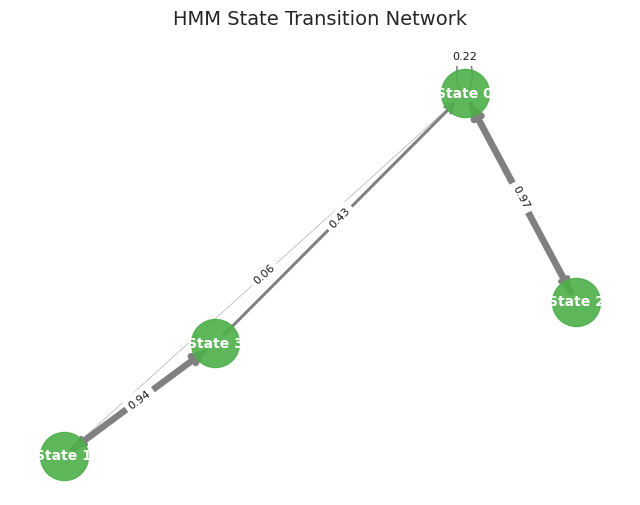

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_hmm_transitions(model, state_labels=None, threshold=0.05):
    """
    HMM 전이확률 네트워크 시각화
    - model.transmat_ 사용
    - threshold 이하 확률은 노이즈라 제외
    """
    n = model.n_components
    if state_labels is None:
        state_labels = [f"State {i}" for i in range(n)]

    G = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            p = model.transmat_[i, j]
            if p > threshold:
                G.add_edge(state_labels[i], state_labels[j], weight=p)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#4daf4a", alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="white", font_weight="bold")

    edges = nx.draw_networkx_edges(
        G, pos,
        arrowstyle="->",
        arrowsize=15,
        width=[d['weight']*5 for (_,_,d) in G.edges(data=True)],
        edge_color="gray"
    )

    edge_labels = {(u,v): f"{d['weight']:.2f}" for (u,v,d) in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("HMM State Transition Network", fontsize=14)
    plt.axis("off")
    plt.show()

plot_hmm_transitions(model)


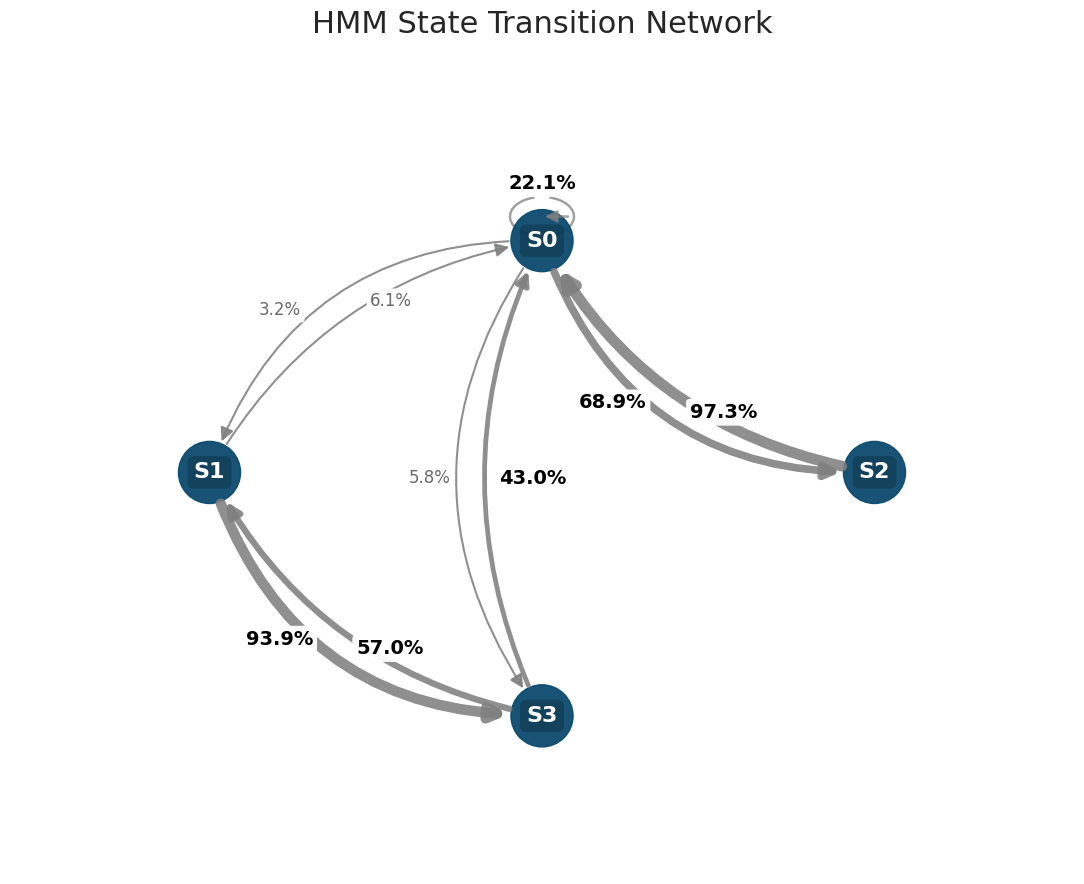

In [ ]:
import joblib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Arc

# ==== 모델 로드 ====
bundle = joblib.load("./hmm_categorical_bundle2.joblib")
model  = bundle["model"]  # hmmlearn.HMM 등

def plot_hmm_midlabels_near(
    model,
    state_labels=None,
    threshold=0.0,          # 0.0 이면 사실상 전부 그림
    figsize=(11, 9),
    sep_main=0.36,          # 쌍방향 중 한쪽 곡률(+)
    sep_rev=-0.24,          # 쌍방향 반대쪽 곡률(-) -> 크기 다르게 해서 더 벌림
    shrink_px=24,           # 화살표-노드 간격(px) : 노드에 가려지지 않도록
    loop_r=0.26,            # self-loop 반경
    label_offset=0.07       # 라벨과 곡선 사이 거리(작을수록 더 붙음)
):
    P = model.transmat_.astype(float)
    n = model.n_components
    labs = state_labels or [f"S{i}" for i in range(n)]

    # 전이(임계치 이상 모두)
    edges = [(i, j, float(P[i, j])) for i in range(n) for j in range(n) if P[i, j] >= threshold]

    # 배치: 4상태면 다이아몬드, 아니면 circular
    if n == 4:
        pos = {
            labs[0]: ( 0.00,  1.00),  # S0
            labs[1]: (-1.35,  0.00),  # S1
            labs[2]: ( 1.35,  0.00),  # S2
            labs[3]: ( 0.00, -1.05),  # S3
        }
    else:
        Gtmp = nx.DiGraph(); [Gtmp.add_edge(labs[i], labs[j]) for i, j, _ in edges]
        pos = nx.circular_layout(Gtmp)

    fig, ax = plt.subplots(figsize=figsize)

    # 노드 (라벨은 살짝 아래로 내려 self-loop와 안 겹치게)
    node_sizes = [2000 for _ in range(n)]
    nx.draw_networkx_nodes(nx.DiGraph(), pos, nodelist=labs, node_size=node_sizes,
                           node_color="#0b4a6e", alpha=0.95, ax=ax)
    for lab in labs:
        x, y = pos[lab]
        ax.text(x, y , lab, ha="center", va="center", fontsize=16, fontweight="bold",
                color="white", bbox=dict(facecolor="black", alpha=0.2, ec="none",
                boxstyle="round,pad=0.28"), zorder=5)

    # ----- 보조 함수 -----
    def mid_and_normal(p0, p1, rad):
        """arc3(rad) 베지어의 중간점(t=0.5)과 단위 법선벡터를 반환"""
        (x1, y1), (x2, y2) = p0, p1
        xm, ym = (x1 + x2) / 2.0, (y1 + y2) / 2.0
        dx, dy = (x2 - x1), (y2 - y1)
        L = np.hypot(dx, dy) + 1e-12
        nxp, nyp = -dy / L, dx / L  # chord에 수직인 단위벡터
        # arc3의 control point
        cx, cy = xm + rad * (L / 2.0) * nxp, ym + rad * (L / 2.0) * nyp
        # quadratic Bezier 중간점 공식: (P0 + 2C + P1) / 4
        mx, my = (x1 + 2 * cx + x2) / 4.0, (y1 + 2 * cy + y2) / 4.0
        # 곡선 바깥쪽을 향하는 법선 방향(곡률 부호 반영)
        nx_out, ny_out = np.sign(rad) * nxp, np.sign(rad) * nyp
        return (mx, my), (nx_out, ny_out)

    def draw_selfloop(xy, p):
        x, y = xy; r = loop_r
        arc = Arc((x, y + r * 0.40), width=r, height=r * 0.65, angle=0,
                  theta1=110, theta2=430, color="gray",
                  lw=max(1.5, 8 * p), alpha=0.75, zorder=1)
        ax.add_patch(arc)
        tip = FancyArrowPatch((x + r * 0.45, y + r * 0.40), (x, y + r * 0.40 + 1e-6),
                              arrowstyle="-|>", mutation_scale=18, color="gray",
                              lw=max(1.5, 8 * p), alpha=0.75, zorder=2)
        ax.add_patch(tip)
        # self-loop 라벨: 곡선 위쪽 중앙
        ax.text(x, y + r * 0.95, f"{p*100:.1f}%",
                ha="center", va="center",
                fontsize=14 if p >= 0.10 else 12,
                fontweight="bold" if p >= 0.10 else "normal",
                color="black" if p >= 0.10 else "dimgray",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.95),
                zorder=10, clip_on=False)

    edge_set = {(labs[i], labs[j]) for i, j, _ in edges}

    # 1) 화살표 먼저(서로 충분히 띄움 + 노드와 간격)
    for i, j, p in edges:
        u, v = labs[i], labs[j]
        u_xy, v_xy = pos[u], pos[v]
        if i == j:
            draw_selfloop(u_xy, p)
            continue
        has_rev = (v, u) in edge_set
        rad = 0.0 if not has_rev else (sep_main if u < v else sep_rev)
        patch = FancyArrowPatch(u_xy, v_xy,
                                connectionstyle=f"arc3,rad={rad}",
                                arrowstyle="-|>", mutation_scale=20,
                                linewidth=max(1.5, 8 * p), color="gray",
                                alpha=0.88, zorder=2,
                                shrinkA=shrink_px, shrinkB=shrink_px)
        ax.add_patch(patch)

    # 2) 라벨: 각 곡선의 '중간점에서 법선 방향'으로 label_offset 만큼 이동
    placed = set()
    for i, j, p in edges:
        u, v = labs[i], labs[j]
        if (u, v) in placed:  # (쌍방향 처리 시) 중복 방지용
            continue
        u_xy, v_xy = pos[u], pos[v]
        if i == j:
            placed.add((u, v)); continue

        has_rev = (v, u) in edge_set
        # 현재(u->v) 곡선
        rad_uv = 0.0 if not has_rev else (sep_main if u < v else sep_rev)
        (mx, my), (nx_out, ny_out) = mid_and_normal(u_xy, v_xy, rad_uv)
        # 기본: 해당 곡선 바깥쪽으로 살짝
        lx, ly = mx + label_offset * nx_out, my + label_offset * ny_out

        if has_rev:
            # 반대(v->u) 곡선도 계산
            rad_vu = sep_main if v < u else sep_rev
            (mx2, my2), (nx2_out, ny2_out) = mid_and_normal(v_xy, u_xy, rad_vu)

            # 두 중간점 x 좌표 비교 → 왼쪽/오른쪽 라벨을 서로 더 벌리기
            if mx <= mx2:
                # (u->v)가 왼쪽, (v->u)가 오른쪽
                lx -= label_offset * 0.6  # 살짝 더 왼쪽으로
                lx2, ly2 = (mx2 + label_offset * nx2_out + label_offset * 0.6,
                            my2 + label_offset * ny2_out)
            else:
                # (u->v)가 오른쪽, (v->u)가 왼쪽
                lx += label_offset * 0.6
                lx2, ly2 = (mx2 + label_offset * nx2_out - label_offset * 0.6,
                            my2 + label_offset * ny2_out)

            # 반대쪽 라벨 먼저/같이 찍기
            p_rev = float(P[j, i])
            ax.text(lx2, ly2, f"{p_rev*100:.1f}%",
                    ha="center", va="center",
                    fontsize=14 if p_rev >= 0.10 else 12,
                    fontweight="bold" if p_rev >= 0.10 else "normal",
                    color="black" if p_rev >= 0.10 else "dimgray",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.95),
                    zorder=10, clip_on=False)
            placed.add((v, u))

        # 현재(u->v) 라벨
        ax.text(lx, ly, f"{p*100:.1f}%",
                ha="center", va="center",
                fontsize=14 if p >= 0.10 else 12,
                fontweight="bold" if p >= 0.10 else "normal",
                color="black" if p >= 0.10 else "dimgray",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.95),
                zorder=10, clip_on=False)
        placed.add((u, v))

    ax.margins(0.30)
    ax.set_title("HMM State Transition Network", fontsize=22)
    ax.axis("off")
    plt.tight_layout(); plt.show()

# ==== 실행 ====
# 서로 충분히 '띄우고' (sep_main/sep_rev), 라벨은 곡선 중간에서 법선 방향으로 '바짝' 붙임
plot_hmm_midlabels_near(
    model,
    threshold=0.02,    # 전부 표시
    sep_main=0.36,    # 필요 시 0.40~0.48로 늘리면 더 벌어짐
    sep_rev=-0.24,    # 필요 시 -0.30 등
    shrink_px=24,     # 화살표-노드 간격
    label_offset=-0.4 # 라벨-곡선 간 거리(0.05~0.10 사이로 미세 조정)
)

In [ ]:
import numpy as np
import pandas as pd

# 가정:
# - model: 학습된 hmmlearn 모델 (bundle["model"])
# - X: (N, d) 관측 배열 (토큰 원핫/임베딩/특징 등)
# - lengths: List[int], 세션(또는 사용자 시퀀스)별 길이
# - session_ids: 길이 N의 배열/시리즈, 각 row가 속한 세션 ID (lengths와 일치하는 순서)
# 예: lengths = [50, 30, 45]  → 총 125행
session_ids = np.concatenate([
    np.repeat(i, l) for i, l in enumerate(lengths)
])

# 1) Posterior(γ) 구하기: 각 타임스텝에서 state별 확률
gamma = model.predict_proba(X, lengths=lengths)   # shape: (N, n_states)

# 2) 세션별 집계 인덱스 만들기
idx = pd.Series(session_ids, name="session_id")
n_states = model.n_components
state_cols = [f"S{i}" for i in range(n_states)]

# 2-1) 지배 state 기준 (세션 평균 posterior의 argmax)
gamma_df = pd.DataFrame(gamma, columns=state_cols)
gamma_df["session_id"] = idx.values
sess_mean = gamma_df.groupby("session_id")[state_cols].mean()
dominant_state = sess_mean.idxmax(axis=1)  # 각 세션의 지배 state 라벨
dominant_counts = dominant_state.value_counts().reindex(state_cols, fill_value=0)

# 2-2) 시작 state 기준 (세션 첫 타임스텝의 posterior argmax)
# lengths를 이용해 각 세션의 시작 row 인덱스 확보
starts = np.r_[0, np.cumsum(lengths)[:-1]]
start_states = gamma[starts].argmax(axis=1)  # 각 세션 시작시 state index
start_counts = pd.Series(start_states).map({i: f"S{i}" for i in range(n_states)}).value_counts()
start_counts = start_counts.reindex(state_cols, fill_value=0)

# 2-3) 시간 분할 분포 (세션을 하나로 단정하지 않고, state별 체류 비율 합계)
time_share = sess_mean.sum(axis=0).reindex(state_cols, fill_value=0)  # 모든 세션의 평균 posterior 합
# 비율로 보고 싶으면:
time_share_norm = time_share / time_share.sum()

# 결과 요약표
summary = pd.DataFrame({
    "Start_count": start_counts.astype(int),
    "Dominant_count": dominant_counts.astype(int),
    "Time_share(%)": (time_share_norm * 100).round(1)
})
print(summary)

    Start_count  Dominant_count  Time_share(%)
S0         4317           81459           16.0
S1       243185          183542           37.4
S2         9454            8189            8.7
S3        61307           45073           37.9


In [ ]:
import pandas as pd

# 기존 결과
data = {
    "State": ["S0", "S1", "S2", "S3"],
    "Start_count": [4317, 243185, 9454, 61307],
    "Dominant_count": [81459, 183542, 8189, 45073],
    "Time_share(%)": [16.0, 37.4, 8.7, 37.9]
}
df_states = pd.DataFrame(data)

# 상태별 단계 설명 매핑
descriptions = {
    "S0": "전환 직전 단계",
    "S1": "메인 탐색 허브",
    "S2": "이탈/보조 단계",
    "S3": "보조 탐색 허브"
}

# 새로운 컬럼 추가 (맨 앞에 넣기 위해 reindex)
df_states["단계 설명"] = df_states["State"].map(descriptions)
df_states = df_states[["단계 설명", "State", "Start_count", "Dominant_count", "Time_share(%)"]]
df_states


,단계 설명,State,Start_count,Dominant_count,Time_share(%)
0,전환 직전 단계,S0,4317,81459,16.0
1,메인 탐색 허브,S1,243185,183542,37.4
2,이탈/보조 단계,S2,9454,8189,8.7
3,보조 탐색 허브,S3,61307,45073,37.9


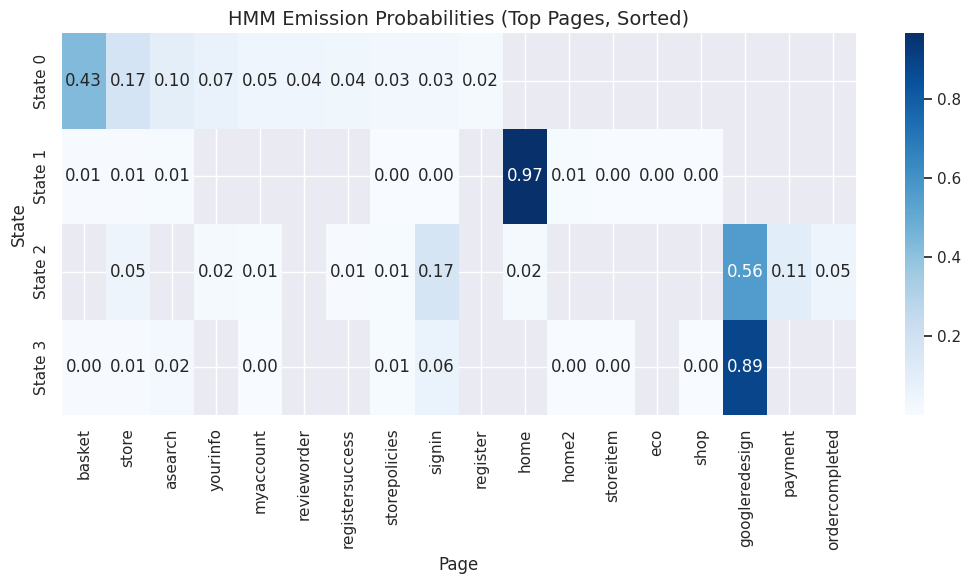

In [ ]:
import seaborn as sns
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emission_heatmap_sorted(model, vocab, top_n=10):
    em = model.emissionprob_
    n_states = model.n_components
    data = []

    # 1) 상태별 Top-N 수집
    per_state_top = []
    for k in range(n_states):
        top_idx = np.argsort(em[k])[::-1][:top_n]
        per_state_top.append([(vocab[i], float(em[k][i])) for i in top_idx])
        for i in top_idx:
            data.append([f"State {k}", vocab[i], float(em[k][i])])

    df_em = pd.DataFrame(data, columns=["State", "Page", "Prob"])

    # 2) 전역 페이지 컬럼 순서 만들기 (상태0의 TopN → 상태1의 TopN → …, 중복 제거 보존)
    pages_order = []
    for k in range(n_states):
        for p, _ in per_state_top[k]:
            if p not in pages_order:
                pages_order.append(p)

    # 3) 카테고리 순서 지정 (중복 없는 전역 순서)
    df_em["Page"] = pd.Categorical(df_em["Page"], categories=pages_order, ordered=True)
    df_em["State"] = pd.Categorical(
        df_em["State"],
        categories=[f"State {k}" for k in range(n_states)],
        ordered=True
    )

    # 4) 피벗 & 히트맵
    pivot = df_em.pivot(index="State", columns="Page", values="Prob")
    plt.figure(figsize=(max(10, len(pages_order)*0.6), 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues")
    plt.title("HMM Emission Probabilities (Top Pages, Sorted)", fontsize=14)
    plt.xlabel("Page")
    plt.ylabel("State")
    plt.tight_layout()
    plt.show()



# 사용 예시
plot_emission_heatmap_sorted(model, le.classes_)

Session states: [1 3]


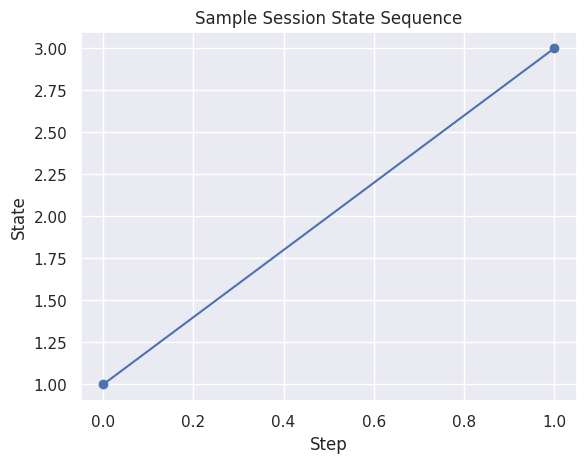

Session states: [1 3 1 3 1]


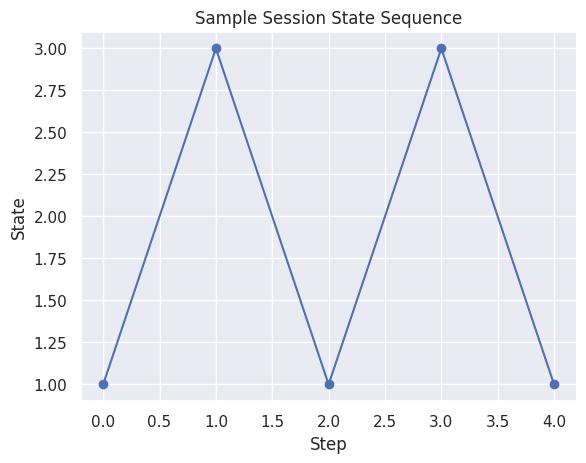

Session states: [1 3]


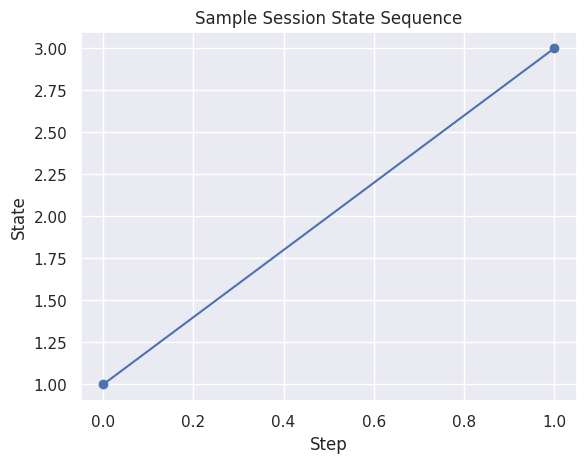

Session states: [3 1]


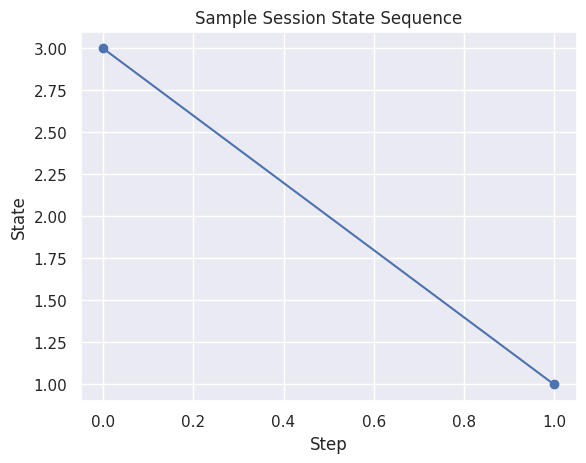

Session states: [1 3]


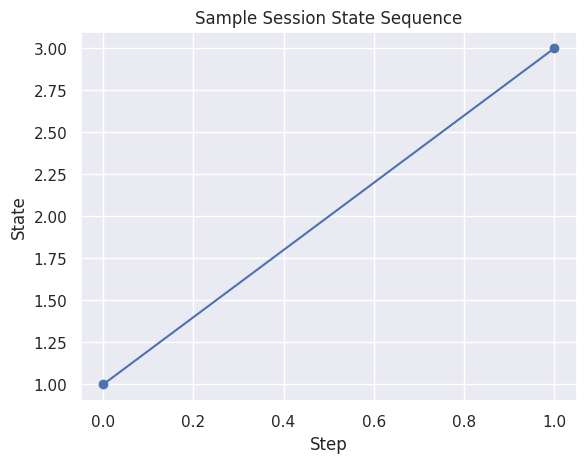

In [ ]:
from matplotlib.sankey import Sankey

def plot_session_states(model, encoded_sessions, n_samples=5):
    """
    임의의 세션 n개 선택해서 상태 흐름 시각화
    """
    import random
    sample_sessions = random.sample(encoded_sessions, n_samples)

    for seq in sample_sessions:
        _, states = model.decode(seq.reshape(-1,1), algorithm="viterbi")
        print("Session states:", states)

        plt.plot(states, marker="o")
        plt.title("Sample Session State Sequence")
        plt.xlabel("Step")
        plt.ylabel("State")
        plt.show()

# 사용 예시
plot_session_states(model, encoded[:100], n_samples=5)  # 처음 100개 중 5개


In [ ]:
# 쿼리 결과 df 기준 (df_fast를 쓰신다면 df_fast로 바꿔주세요)
# df_fast = df_fast.copy()


# 학습 당시의 encoder
# le: LabelEncoder
vocab_set = set(le.classes_)

def enc_known(seq):
    # 학습 때 본 토큰만 인코딩 (모르는 토큰은 drop)
    known = [tok for tok in seq if tok in vocab_set]
    if not known:
        return np.array([], dtype=int)
    return le.transform(known).astype(int)

df_fast["seq_tokens"] = df_fast["seq"].apply(enc_known)



import numpy as np

def viterbi_states_from_tokens(tokens):
    if tokens is None or len(tokens) < 2:
        return np.array([], dtype=int)
    _, states = model.decode(tokens.reshape(-1, 1), algorithm="viterbi")
    return states

df_fast["state_seq"] = df_fast["seq_tokens"].apply(viterbi_states_from_tokens)

In [ ]:
# seq → 인코딩 → viterbi → state_seq (길이<2면 빈 배열)
df_fast["state_seq"] = df_fast["seq"].apply(
    lambda s: viterbi_states(enc(s)) if len(s) > 1 else np.array([], dtype=int)
)

from collections import Counter

def count_transitions_from_df(df, state_col="state_seq"):
    c = Counter()
    for seq in df[state_col]:
        if seq is None or len(seq) < 2:
            continue
        c.update(zip(seq[:-1], seq[1:]))
    return c

import plotly.graph_objects as go
import numpy as np

def sankey_from_counts(trans_counter, model, vocab, title="Sankey", top_k=20, top_n_labels=3):
    """
    trans_counter: Counter({(i,j): count})
    model: HMM 모델 (emissionprob_ 사용)
    vocab: le.classes_ (토큰 문자열 배열)
    top_k: 상위 K개 전이만 그림
    top_n_labels: 상태 라벨에 붙일 상위 방출어 개수
    """
    if not trans_counter:
        print(f"[{title}] 표시할 전이가 없습니다.")
        return

    # 상위 전이만 사용
    items = trans_counter.most_common(top_k)
    edges = [(int(i), int(j), int(w)) for (i,j), w in items]

    # 노드(상태) 목록
    nodes = sorted(set([i for i,_,_ in edges]) | set([j for _,j,_ in edges]))
    node_to_idx = {s: k for k, s in enumerate(nodes)}

    # 상태 라벨: "S{s}: page1, page2, ..."
    E = model.emissionprob_  # (n_states, n_features)
    def top_label(s, n=top_n_labels):
        idx = np.argsort(E[s])[::-1][:n]
        names = [str(vocab[i]) for i in idx]
        return f"S{s}: " + ", ".join(names)
    labels = [top_label(s) for s in nodes]

    # 링크
    src = [node_to_idx[i] for i,_,_ in edges]
    dst = [node_to_idx[j] for _,j,_ in edges]
    val = [w for *_, w in edges]

    fig = go.Figure(data=[go.Sankey(
        valueformat=".0f",
        node=dict(
            pad=16, thickness=18,
            label=labels,
            hovertemplate='%{label}<extra></extra>'
        ),
        link=dict(
            source=src, target=dst, value=val,
            hovertemplate='From %{source.label}<br>to %{target.label}<br>count: %{value}<extra></extra>'
        )
    )])
    fig.update_layout(title_text=title, font_size=11)
    fig.show()


In [ ]:
from collections import Counter

def count_transitions_from_series(series):
    c = Counter()
    for seq in series:
        if seq is None or len(seq) < 2:
            continue
        c.update(zip(seq[:-1], seq[1:]))
    return c

# 전체 / 장바구니 도달 / 매출 발생
all_trans     = count_transitions_from_series(df_fast["state_seq"])
non_basket_trans  = count_transitions_from_series(df_fast.loc[df_fast["converted_basket"]==0, "state_seq"])
basket_trans  = count_transitions_from_series(df_fast.loc[df_fast["converted_basket"]==1, "state_seq"])
revenue_trans = count_transitions_from_series(df_fast.loc[df_fast["converted_revenue"]==1, "state_seq"])

# Sankey (앞서 만든 함수 재사용)
sankey_from_counts(all_trans, model, le.classes_, title="[HMM] 전체", top_k=20)
sankey_from_counts(non_basket_trans, model, le.classes_, title="[HMM] 장바구니 미도달", top_k=20)
sankey_from_counts(basket_trans, model, le.classes_, title="[HMM] 장바구니 도달", top_k=20)
sankey_from_counts(revenue_trans, model, le.classes_, title="[HMM] 매출 전환", top_k=20)


In [ ]:
def trans_share(counter, edge):
    total = sum(counter.values())
    return counter[edge] / total if total > 0 else 0

edges = [(0,2),(2,0),(1,3),(3,0)]
for e in edges:
    print(f"{e} | 전체 {trans_share(all_trans,e):.2%} | "
          f"Non_Basket {trans_share(non_basket_trans,e):.2%} | "
          f"Basket {trans_share(basket_trans,e):.2%} | "
          f"Revenue {trans_share(revenue_trans,e):.2%}")


(0, 2) | 전체 20.30% | Non_Basket 7.42% | Basket 32.72% | Revenue 39.03%
(2, 0) | 전체 16.40% | Non_Basket 4.69% | Basket 27.68% | Revenue 33.85%
(1, 3) | 전체 31.16% | Non_Basket 52.71% | Basket 10.39% | Revenue 5.43%
(3, 0) | 전체 9.76% | Non_Basket 8.82% | Basket 10.67% | Revenue 6.11%


In [ ]:
non_df = df_fast[(df_fast["converted_basket"]==0) & (df_fast["converted_revenue"]==0)]
bsk_df = df_fast[df_fast["converted_basket"]==1]
rev_df = df_fast[df_fast["converted_revenue"]==1]

In [ ]:
import numpy as np
from collections import Counter

def empirical_transmat(state_seqs, n_states, laplace=1e-6):
    # 전이 카운트
    counts = np.zeros((n_states, n_states), dtype=float)
    for seq in state_seqs:
        if seq is None:
            continue
        arr = np.asarray(seq, dtype=int)
        if arr.size < 2:
            continue
        for a, b in zip(arr[:-1], arr[1:]):
            if 0 <= a < n_states and 0 <= b < n_states:
                counts[a, b] += 1.0
    # 라플라스 스무딩 + 행 정규화
    counts += laplace
    row_sums = counts.sum(axis=1, keepdims=True)
    row_sums[row_sums==0] = 1.0
    return counts / row_sums


In [ ]:
K = model.n_components  # 예: 4

T_non = empirical_transmat(non_df["state_seq"], K)
T_bsk = empirical_transmat(bsk_df["state_seq"], K)
T_rev = empirical_transmat(rev_df["state_seq"], K)

def print_diff(A, B, title):
    print(f"\n{title}")
    D = A - B
    for i in range(D.shape[0]):
        row = " ".join(f"{D[i,j]:+0.006f}" for j in range(D.shape[1]))
        print(f"From {i}: {row}")

print_diff(T_bsk, T_non, "Basket - NonBasket (Empirical Transition Prob Diff)")
print_diff(T_rev, T_non, "Revenue - NonBasket (Empirical Transition Prob Diff)")


Basket - NonBasket (Empirical Transition Prob Diff)
From 0: +0.111579 -0.062243 +0.001082 -0.050418
From 1: +0.096920 +0.000000 +0.000000 -0.096920
From 2: -0.006452 +0.004676 +0.001695 +0.000081
From 3: +0.428546 -0.428546 +0.000000 +0.000000

Revenue - NonBasket (Empirical Transition Prob Diff)
From 0: +0.117722 -0.075336 +0.024087 -0.066473
From 1: +0.073771 +0.000000 +0.000000 -0.073771
From 2: -0.008321 +0.006561 +0.001726 +0.000035
From 3: +0.539857 -0.539857 +0.000000 +0.000000


In [ ]:
# What‑if 시뮬레이션

def simulate_reach_prob(transmat, start_state, target_state, steps=10, n_sim=20000, rng=None):
    rng = np.random.default_rng(rng)
    n = transmat.shape[0]
    hit = 0
    for _ in range(n_sim):
        s = start_state
        for _ in range(steps):
            s = rng.choice(n, p=transmat[s])
            if s == target_state:
                hit += 1
                break
    return hit / n_sim

# 베이스: 비전환군 전이행렬
base_T = T_non
base_prob = simulate_reach_prob(base_T, start_state=0, target_state=2, steps=10)
print(f"Baseline (Non) reach 0→…→2 in ≤10 steps: {base_prob:.3%}")


Baseline (Non) reach 0→…→2 in ≤10 steps: 94.170%


In [ ]:
# 전이행렬 조정(예: (1→3) 줄이고 (1→2) 강화):

def adjust_transition(transmat, from_state, to_reduce=None, to_increase=None, reduce_factor=0.5):
    T = transmat.copy().astype(float)
    row = T[from_state].copy()
    if to_reduce is not None:
        row[to_reduce] *= reduce_factor
        gap = 1.0 - row.sum()
        if to_increase is not None:
            row[to_increase] += gap
        else:
            idx = np.where(row>0)[0]
            if len(idx)==0:
                row[:] = 1.0/len(row)
            else:
                row[idx] += gap * (row[idx]/row[idx].sum())
    row /= row.sum()
    T[from_state] = row
    return T

# 예: (1→3) 50%로 줄이고 줄인 확률은 (1→2)에 가산
T_new = adjust_transition(base_T, from_state=1, to_reduce=3, to_increase=2, reduce_factor=0.5)
new_prob = simulate_reach_prob(T_new, start_state=0, target_state=2, steps=10)
print(f"What-if reach prob: {new_prob:.3%} (Δ {new_prob - base_prob:+.3%})")


What-if reach prob: 99.710% (Δ +5.540%)


## 시각화

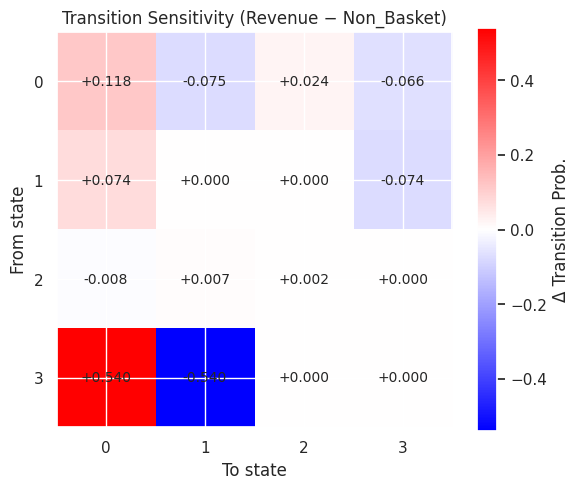

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----- 유틸: 경험적 전이확률 행렬 -----
def empirical_transmat(state_seqs, n_states, laplace=1e-6):
    counts = np.zeros((n_states, n_states), dtype=float)
    for seq in state_seqs:
        if seq is None:
            continue
        arr = np.asarray(seq, dtype=int)
        if arr.size < 2:
            continue
        for a, b in zip(arr[:-1], arr[1:]):
            if 0 <= a < n_states and 0 <= b < n_states:
                counts[a, b] += 1.0
    counts += laplace
    row_sums = counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    return counts / row_sums

# ----- 그룹 분리 (필요시 df_fast → df로 변경) -----
non_df = df_fast[(df_fast["converted_basket"]==0) & (df_fast["converted_revenue"]==0)]
rev_df = df_fast[df_fast["converted_revenue"]==1]

K = model.n_components
T_non = empirical_transmat(non_df["state_seq"], K)
T_rev = empirical_transmat(rev_df["state_seq"], K)

# ----- 히트맵 그리기 -----
def plot_transition_sensitivity(T_ref, T_cmp, title="Transition Sensitivity (Cmp − Ref)"):
    D = T_cmp - T_ref
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(D, cmap="bwr", vmin=-np.max(np.abs(D)), vmax=np.max(np.abs(D)))
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            ax.text(j, i, f"{D[i,j]:+.3f}", ha="center", va="center", fontsize=10)
    ax.set_xticks(range(D.shape[1])); ax.set_yticks(range(D.shape[0]))
    ax.set_xlabel("To state"); ax.set_ylabel("From state")
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Δ Transition Prob.")
    plt.tight_layout(); plt.show()

# Revenue − Non_Basket (보고서용 메인)
plot_transition_sensitivity(T_non, T_rev,
    title="Transition Sensitivity (Revenue − Non_Basket)")


[결과해석]
- State 0 → State 0 전이 (+0.118)  
: Revenue 그룹은 동일한 탐색 상태에 머무르는 비율이 높음 → 안정적이고 지속적인 탐색을 의미.

- State 0 → State 1/3 전이 감소  
: Revenue 그룹은 홈 반복이나 빠른 이탈로 넘어가는 급격한 전환이 적고, 점진적으로 Funnel을 진행하는 특징.

- State 3 → State 0 전이 크게 증가 (+0.540)  
: 이탈처럼 보이는 행동에서도 다시 탐색 단계로 복귀하는 경우가 많음 → “리커버리 가능성”이 높은 고객군임을 시사.

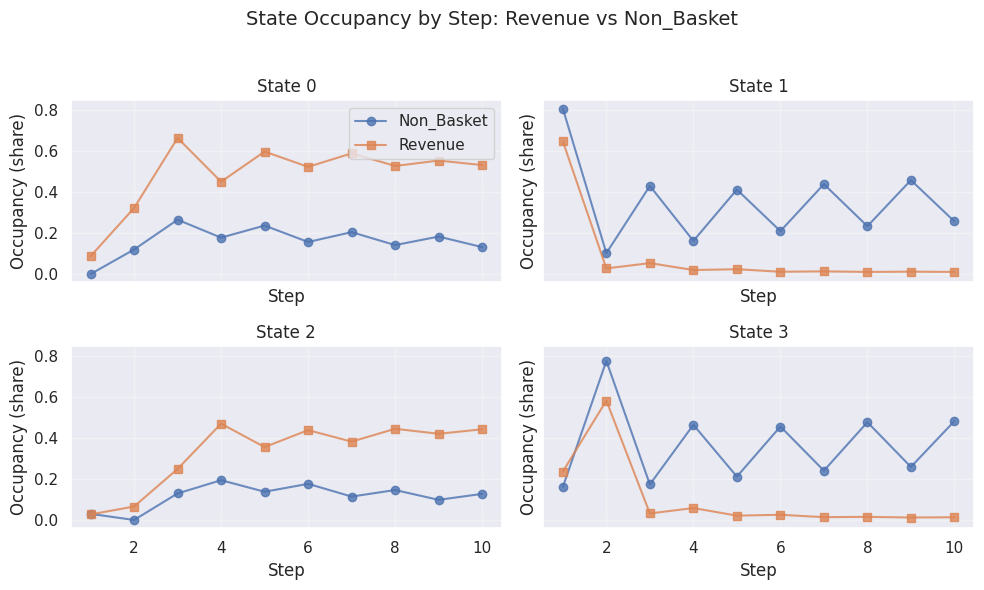

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def state_occupancy_over_steps(state_seqs, n_states, max_steps=10):
    """
    step t (1..max_steps)에서 각 상태의 점유 비율을 반환: shape = (max_steps, n_states)
    """
    occ = np.zeros((max_steps, n_states), dtype=float)
    counts = np.zeros(max_steps, dtype=int)
    for seq in state_seqs:
        arr = np.asarray(seq, dtype=int)
        L = min(len(arr), max_steps)
        if L == 0:
            continue
        for t in range(L):
            s = arr[t]
            if 0 <= s < n_states:
                occ[t, s] += 1
        counts[:L] += 1
    counts[counts==0] = 1  # 0 나눗셈 방지
    occ = occ / counts[:, None]
    return occ

max_steps = 10
occ_non = state_occupancy_over_steps(non_df["state_seq"], K, max_steps=max_steps)
occ_rev = state_occupancy_over_steps(rev_df["state_seq"], K, max_steps=max_steps)

# ----- 라인플롯: 상태별로 Revenue vs Non 비교 -----
fig, axes = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)
axes = axes.ravel()
steps = np.arange(1, max_steps+1)

for s in range(K):
    ax = axes[s]
    ax.plot(steps, occ_non[:, s], marker="o", label="Non_Basket", alpha=0.8)
    ax.plot(steps, occ_rev[:, s], marker="s", label="Revenue", alpha=0.8)
    ax.set_title(f"State {s}")
    ax.set_xlabel("Step"); ax.set_ylabel("Occupancy (share)")
    ax.grid(alpha=0.3)
    if s==0: ax.legend()

fig.suptitle("State Occupancy by Step: Revenue vs Non_Basket", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96]); plt.show()


### 해석

- S0(탐색) : Revenue 그룹은 점차적으로 점유율이 상승하며 지속적인 탐색 후 구매로 이어지는 패턴으로 Non basket은 점유율이 낮고 금방 흩어짐
- S1(홈 반복)